# (11468) Shantanunaidu orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '11468'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_hires = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_mpc_optical_obs_array(body_id, de_kernel_path, optical_obs_file, t_min_tdb, t_max_tdb, debias_hires, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_array_gaia, observer_codes_gaia = fit.get_gaia_optical_obs_array(body_id, de_kernel_path, t_min_tdb, t_max_tdb, gaia_dr, verbose)
    obs_array_optical = np.vstack((obs_array_optical, obs_array_gaia))
    observer_codes_optical = observer_codes_optical + observer_codes_gaia

Skipped 0 observations 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 710 observations. Debiased 990 observations. No biasing information for 24 observations.
Applied default weight of 1 arcsec to 150 CCD observations
Deweighted 436 observations as part of deweighting scheme.
Found 308 observations from gaiafpr
	 Added 308 of those observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.439			 6.350			 1208.462			 0.298
2			 0.445			 6.222			 2245.410			 0.553
3			 0.445			 6.222			 2245.433			 0.553
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.403			 6.138			 1155.538			 0.290
5			 0.409			 6.148			 1155.313			 0.292
6			 0.411			 6.161			 1180.118			 0.298
7			 0.411			 6.162			 1181.149			 0.298
Converged after rejecting outliers. Rejected 49 out of 2032 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 7 (of 7):
RMS unweighted: 0.411260809339473
RMS weighted: 6.161783511560436
chi-squared: 1181.148932584869
reduced chi-squared: 0.29826993247092654
square root of reduced chi-squared: 0.5461409456092141
--------------------------------------------------------------
Solution Time: MJD 57585.000 TDB = 2016-07-16 00:00:00.000 TDB
Solution Observation Arc: 15736.77 days (43.08 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			1.66677719435e-01		2.26937840825e-09 		1.66677811385e-01		2.21965617898e-09 		+9.19493917950e-08		+40.517
q			2.56501696354e+00		2.93106325789e-09 		2.56501676561e+00		2.71663138802e-09 		-1.97935858370e-07		-67.530
tp			5.75113094667e+04		4.23787045746e-06 		5.75113096369e+04		4.21134855925e-06 		+1.70222971065e-04		+40.167
om			2.06374469619e+02		6.73599568460e-06 		2.06374063268e+02		6.25262

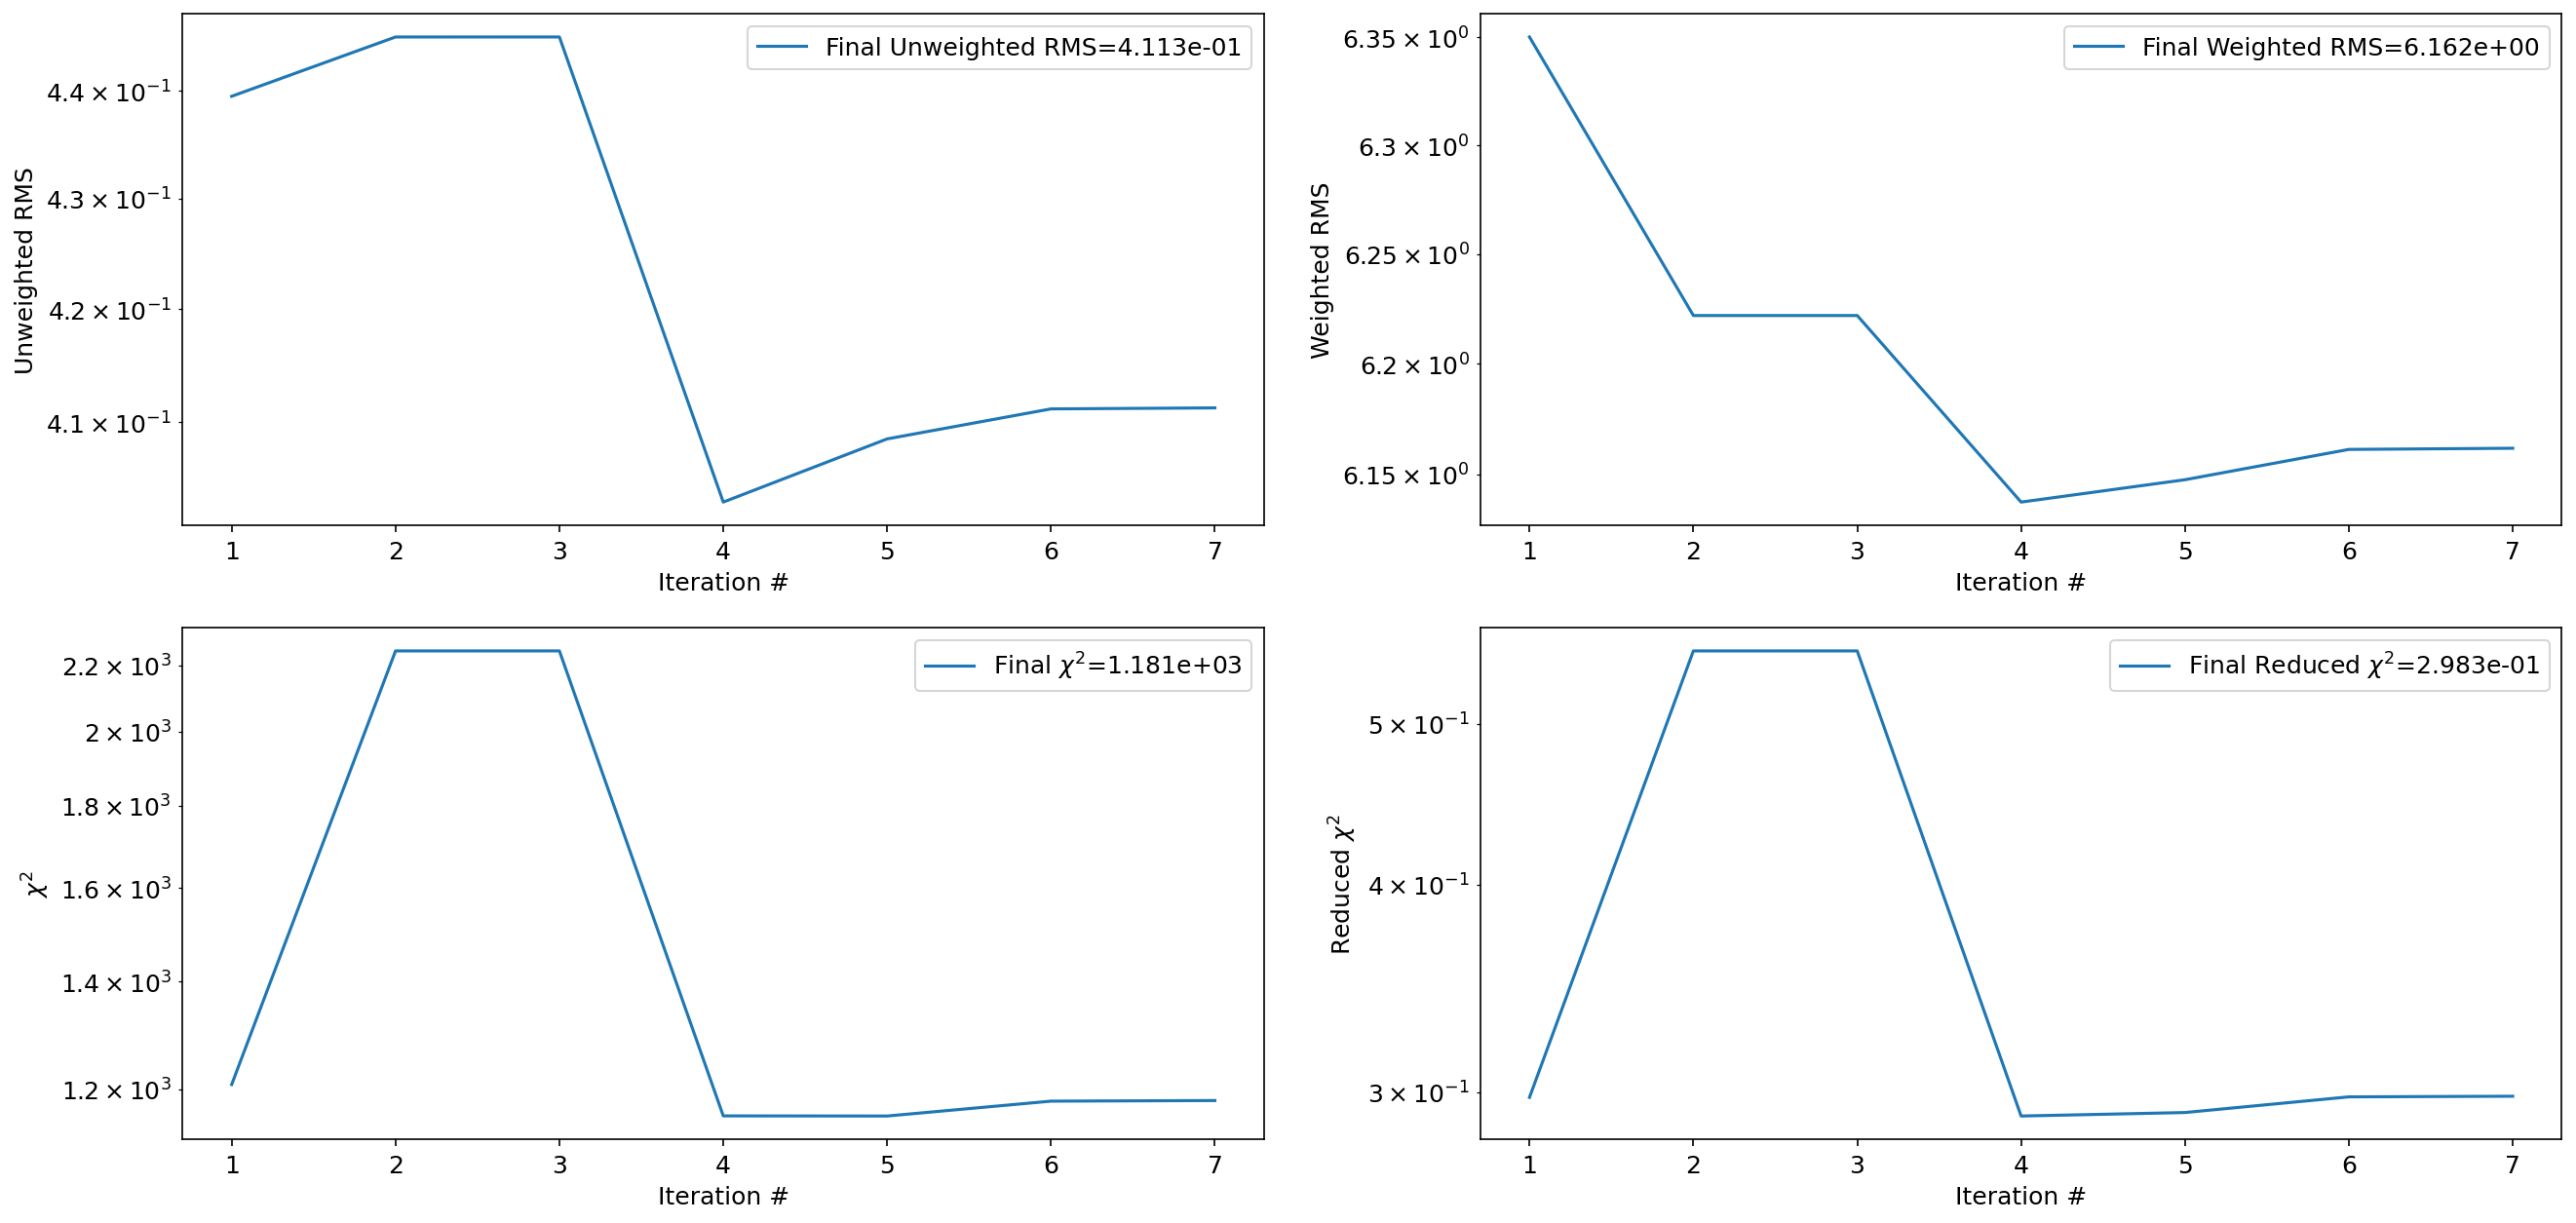

In [8]:
fit_sim.plot_summary(auto_close=True)

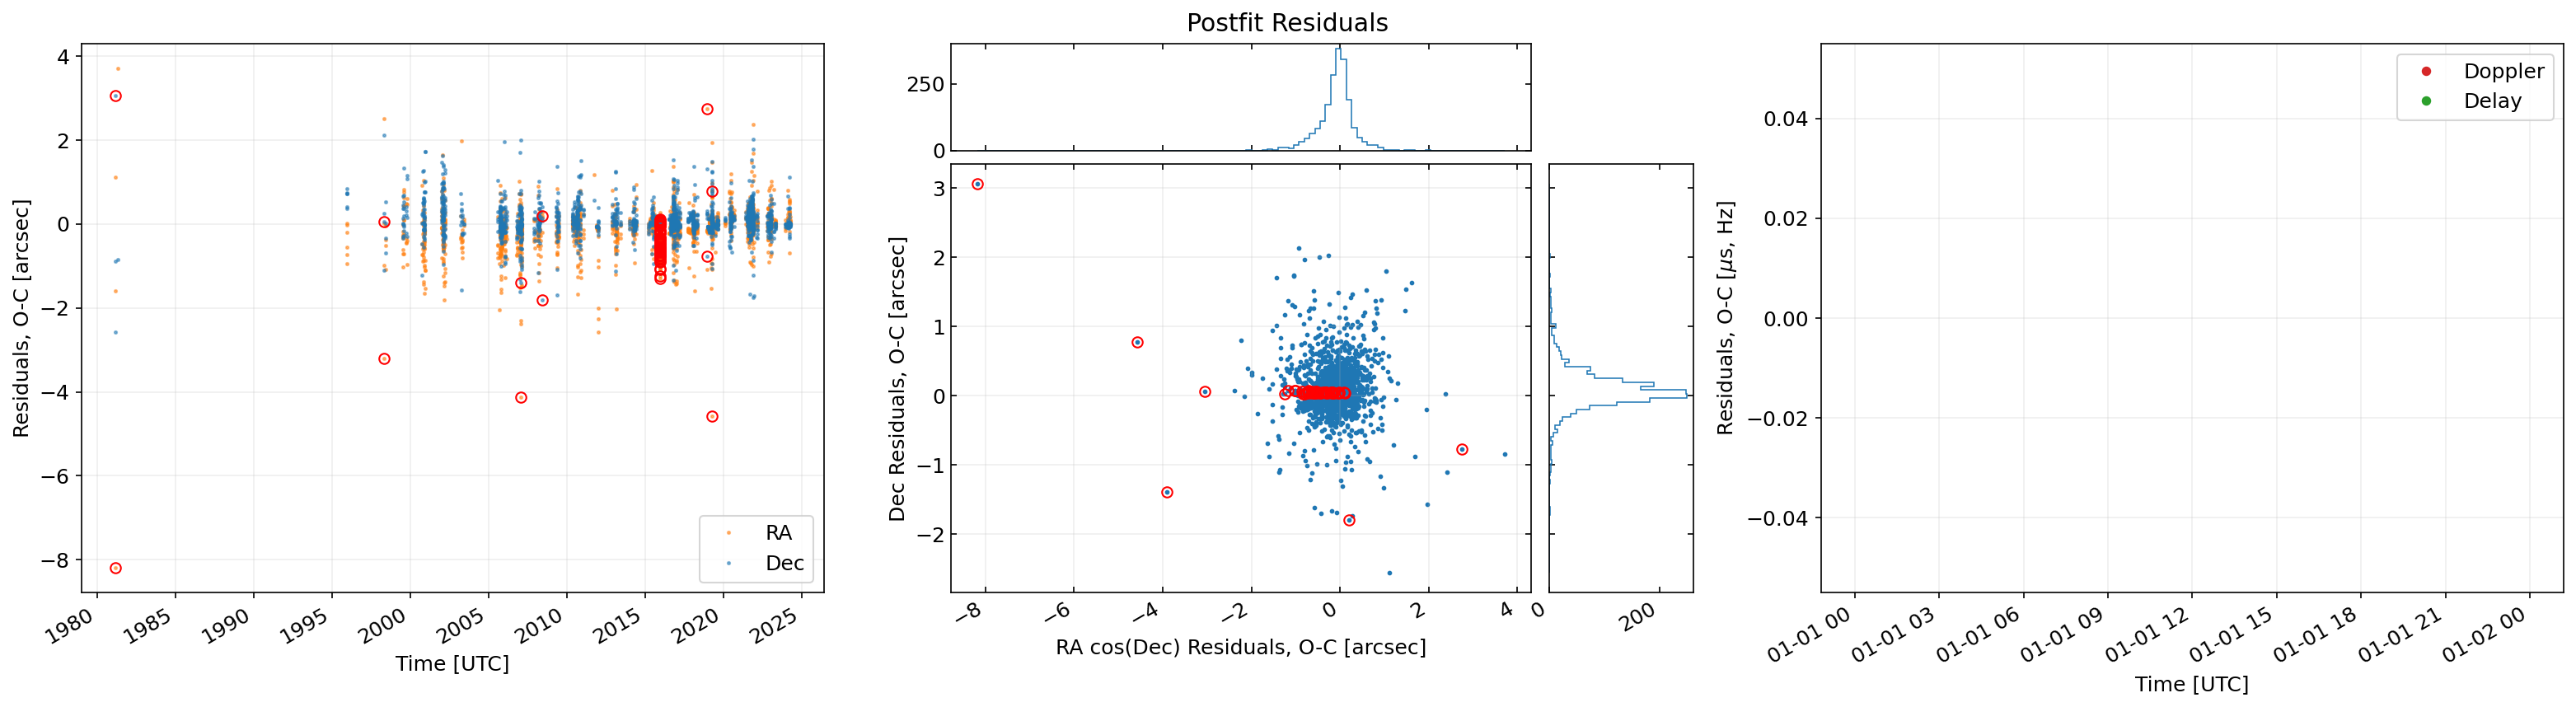

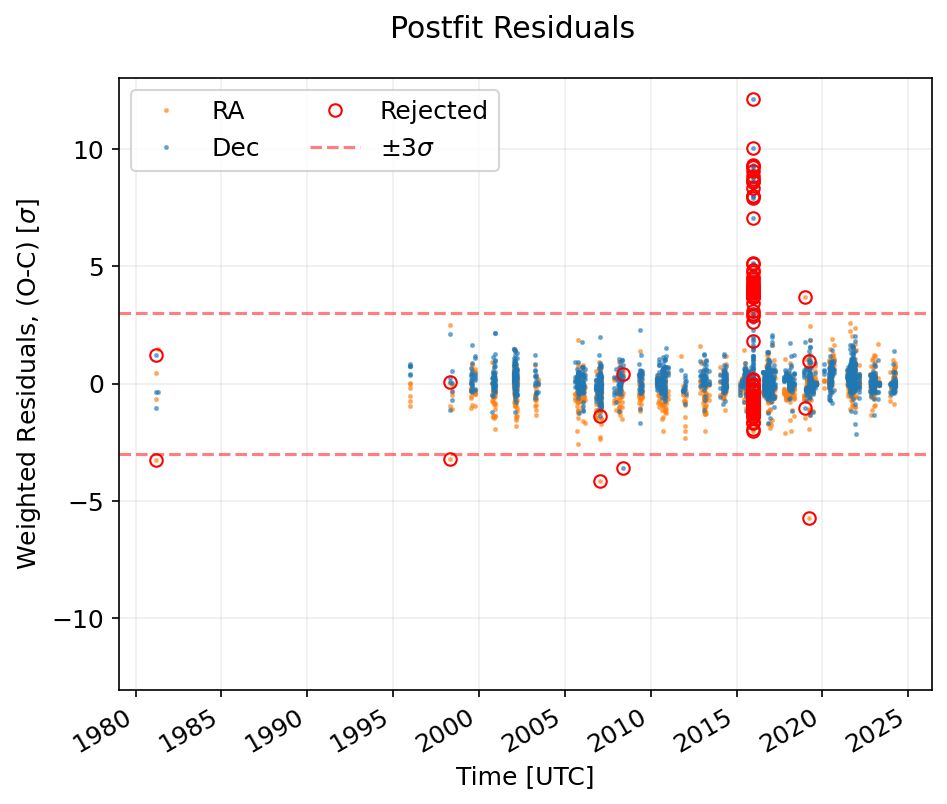

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 156.56
Mahalonobis distance between GRSS and JPL solution: 157.91
Bhattacharya distance between JPL and GRSS solution: -0.0020
Bhattacharya coefficient between JPL and GRSS solution: 1.0020


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90

AssertionError: 